## Sensors Data Classification

### Load packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import itertools
import sklearn.pipeline
import sklearn.decomposition
import sklearn.svm
import sklearn.neighbors
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics

### Define constants

In [2]:
_SENSOR_LABELS = ["S-1", "S-2", "S-3", "S-4", "S-5", "S-6", "S-7", "S-8"]
_FEATURE_LIST = ["DeltaH", "DeltaL", "SlopeH", "SlopeL"]
_TEMPERATURE_MODULATION = ["Sine", "Square", "Triangle", "Sq+Tr"]

### Load Features

In [3]:
# Load data and change concentration
features = pd.read_csv("complete_features_trial002.csv", index_col=0)
features.loc[features.Concentration == 131, "Concentration"] = 130
features = features[features["Repetition"] > 0].reset_index(drop=True)
features = features[features["Repetition"] < 11].reset_index(drop=True)
features.head()

,Compound,Concentration,DeltaH,DeltaL,SlopeH,SlopeL,AreaH,AreaL,Temperature Modulation,Sensor,Repetition
0,BUT,75,2249.374904,2248.579273,46.093748,-22485.792731,852308.583473,139759.565388,Sq+Tr,S-1,1.0
1,BUT,75,2212.280968,2212.440094,45.056639,-22124.400940,836758.618637,138540.193544,Sq+Tr,S-1,2.0
2,BUT,75,2198.519365,2197.087765,44.959496,-10985.438827,831463.821187,137985.681482,Sq+Tr,S-1,3.0
3,BUT,75,2188.970715,2189.129762,44.491275,-21891.297616,827717.846053,138984.558244,Sq+Tr,S-1,4.0
4,BUT,75,2184.833718,2183.243077,44.407189,-10916.215385,825830.190600,137502.466261,Sq+Tr,S-1,5.0


In [4]:
# Load data and change concentration
features_t1 = pd.read_csv("complete_features_trial001.csv", index_col=0)
features_t1.loc[features_t1.Concentration == 131, "Concentration"] = 130
features_t1 = features_t1[features_t1["Repetition"] > 0].reset_index(drop=True)
features_t1 = features_t1[features_t1["Repetition"] < 3].reset_index(drop=True)
features_t1.loc[features_t1.Repetition == 1, "Repetition"] = 11
features_t1.loc[features_t1.Repetition == 2, "Repetition"] = 12
features_t1.head()

,Compound,Concentration,DeltaH,DeltaL,SlopeH,SlopeL,AreaH,AreaL,Temperature Modulation,Sensor,Repetition
0,BUT,75,563.875842,581.186416,11.368465,-15.135063,180328.492030,35269.887424,Sq+Tr,S-1,11.0
1,BUT,75,565.247719,577.091777,11.396123,-15.028432,181710.016002,34888.558708,Sq+Tr,S-1,12.0
2,BUT,75,1069.294624,1071.861197,21.558359,-27.840551,400767.998804,74904.747802,Sq+Tr,S-2,11.0
3,BUT,75,1055.697797,1060.510271,21.284230,-27.262475,392330.608202,74713.639563,Sq+Tr,S-2,12.0
4,BUT,75,672.595881,673.842008,13.560401,-2246.140028,245772.894848,56281.994993,Sq+Tr,S-3,11.0


In [5]:
features_concat = pd.concat((features, features_t1)).reset_index(drop=True)
features_concat.tail()
features_concat = features.copy()

### Remap Features

In [6]:
# Generate new column names
all_columns = list(
    itertools.product(_SENSOR_LABELS, _FEATURE_LIST, _TEMPERATURE_MODULATION)
)
all_columns = [f"{x[0]}-{x[1]}-{x[2]}" for x in all_columns]

all_columns.append("Concentration")
all_columns.append("Compound")

# Set up new dataframe
features_remapped = pd.DataFrame()
features_remapped["Concentration"] = features_concat.loc[
    (features_concat.Sensor == "S-1") & (features_concat["Temperature Modulation"] == "Sine"),
    "Concentration",
]
features_remapped["Compound"] = features.loc[
    (features_concat.Sensor == "S-1") & (features_concat["Temperature Modulation"] == "Sine"),
    "Compound",
]

features_remapped["Repetition"] = features_concat.loc[
    (features_concat.Sensor == "S-1") & (features_concat["Temperature Modulation"] == "Sine"),
    "Repetition",
]
features_remapped = features_remapped.reset_index(drop=True)
print(features_remapped.shape)

for sensor in _SENSOR_LABELS:
    for feature in _FEATURE_LIST:
        for temp_mod in _TEMPERATURE_MODULATION:
            temp_df = features_concat.loc[
                (features_concat.Sensor == sensor)
                & (features_concat["Temperature Modulation"] == temp_mod),
                [feature, "Concentration", "Compound", "Repetition"],
            ]
            temp_df[f"{sensor}-{feature}-{temp_mod}"] = temp_df[feature]
            temp_df = temp_df.drop(feature, axis=1)
            features_remapped = pd.merge(
                features_remapped,
                temp_df,
                on=["Concentration", "Compound", "Repetition"],
                how="outer",
            )
features_remapped = features_remapped.dropna(axis=0)

(90, 3)


### Remove NaN

In [7]:
features_remapped_dropna = features_remapped.dropna(axis=0).copy()

### Normalize Features

In [8]:
features_var_dropna_norm = features_remapped_dropna.drop(
    ["Concentration", "Compound", "Repetition"], axis=1
)

### Training Set

In [9]:
x = features_var_dropna_norm.values
y_compound = features_remapped_dropna["Compound"].values

In [10]:
print(f"X shape: {x.shape}")
print(f"Y shape: {y_compound.shape}")

X shape: (90, 128)
Y shape: (90,)


In [11]:
random_state = 42
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y_compound, random_state=random_state, train_size=0.7)
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")

x_train shape: (62, 128)
x_test shape: (28, 128)


In [52]:
pipeline = sklearn.pipeline.Pipeline(
    (
        ('Normalize', sklearn.preprocessing.MinMaxScaler()),
        ('PCA', sklearn.decomposition.PCA(n_components=2)),
        ('kNN', sklearn.neighbors.KNeighborsClassifier(n_neighbors=3))
    )
)

In [53]:
def remap_features(features, sensors, t_pattern):
    if isinstance(t_pattern, str):
        t_pattern = [t_pattern]
    if isinstance(sensors, str):
        sensors = [sensors]
    # Generate new column names
    all_columns = list(
        itertools.product(sensors, _FEATURE_LIST, t_pattern)
    )
    all_columns = [f"{x[0]}-{x[1]}-{x[2]}" for x in all_columns]
    all_columns.append("Concentration")
    all_columns.append("Compound")

    # Set up new dataframe
    features_remapped = pd.DataFrame()
    features_remapped["Concentration"] = features.loc[
        (features.Sensor == sensors[0]) & (features["Temperature Modulation"] == t_pattern[0]),
        "Concentration",
    ]
    features_remapped["Compound"] = features.loc[
        (features.Sensor == sensors[0]) & (features["Temperature Modulation"] == t_pattern[0]),
        "Compound",
    ]

    features_remapped["Repetition"] = features.loc[
        (features.Sensor == sensors[0]) & (features["Temperature Modulation"] == t_pattern[0]),
        "Repetition",
    ]
    features_remapped = features_remapped.reset_index(drop=True)

    for sensor in sensors:
        for feature in _FEATURE_LIST:
            for temp_mod in t_pattern:
                temp_df = features.loc[
                    (features.Sensor == sensor)
                    & (features["Temperature Modulation"] == temp_mod),
                    [feature, "Concentration", "Compound", "Repetition"],
                ]
                temp_df[f"{sensor}-{feature}-{temp_mod}"] = temp_df[feature]
                temp_df = temp_df.drop(feature, axis=1)
                features_remapped = pd.merge(
                    features_remapped,
                    temp_df,
                    on=["Concentration", "Compound", "Repetition"],
                    how="outer",
                )
                
    return features_remapped

In [54]:
sensor_groups = [
                 ['S-1','S-2','S-3','S-4'],
                 ['S-5','S-6'],
                 ['S-7','S-8'],
                 #['S-1','S-2','S-3','S-4','S-5','S-6'],
                 #['S-5','S-6','S-7','S-8'],
                 #['S-1','S-2','S-3','S-4','S-7','S-8'],
                 #['S-1','S-2','S-3','S-4','S-5','S-6','S-7','S-8']
                ]

t_patterns = features["Temperature Modulation"].unique()
random_state = 42

t_patterns = ["Sq+Tr"]

for sensor_group in sensor_groups:
    print(sensor_group)
    for t_pattern in t_patterns:
        print(t_pattern)
        tmp_features = remap_features(features_concat, sensor_group, t_pattern)        
        tmp_features_x = tmp_features.drop(
            ["Concentration", "Compound", "Repetition"], axis=1)
        print(tmp_features_x.shape)

        x = tmp_features_x.values
        y_compound = tmp_features["Compound"].values
        y_concentration = tmp_features["Concentration"].apply(lambda x: str(x)).values
        y = y_compound + y_concentration

        x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, 
                                                                                    random_state=random_state, 
                                                                                    train_size=0.8)
        label_encoder = sklearn.preprocessing.LabelEncoder()
        label_encoder.fit(y_train)
        y_train = label_encoder.transform(y_train)
        y_test = label_encoder.transform(y_test)
        #print(x_test.shape)
        
        pipeline.fit(x_train, y_train)
        #print(y_test)
        print(sklearn.metrics.accuracy_score(y_test, pipeline.predict(x_test)))
        

['S-1', 'S-2', 'S-3', 'S-4']
Sq+Tr


(90, 16)
1.0
['S-5', 'S-6']
Sq+Tr
(90, 8)
1.0
['S-7', 'S-8']
Sq+Tr
(90, 8)
1.0


c:\Users\davide.marzorati\Desktop\Dev\Python\virtual_envs\dev\lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\Users\davide.marzorati\Desktop\Dev\Python\virtual_envs\dev\lib\site-packages\seaborn\axisgrid.py:717: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


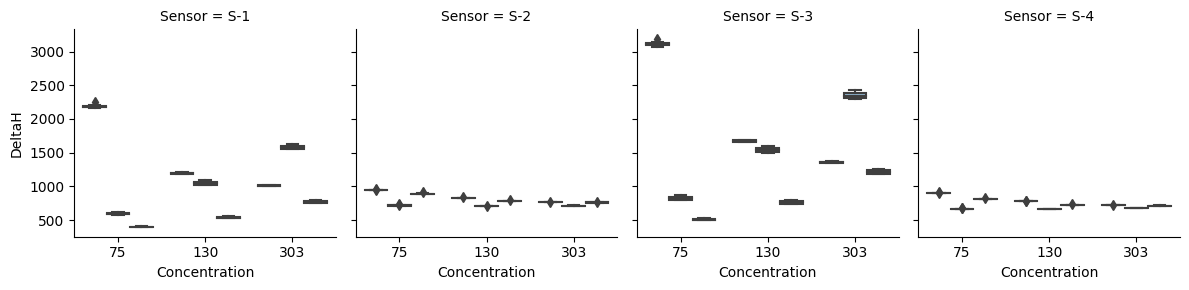

In [191]:
g = sns.FacetGrid(data=features[(features["Temperature Modulation"] == "Sq+Tr") & (features.Sensor.isin(["S-1", "S-2", "S-3", "S-4"]))], col="Sensor")
g.map(sns.boxplot, "Concentration", "DeltaH", "Compound")
#sns.boxplot(data=features[(features["Temperature Modulation"] == "Sq+Tr") & (features["Sensor"].isin(["S-1", "S-2", "S-3", "S-4"]))], x="Compound", y="DeltaH", hue="Sensor")

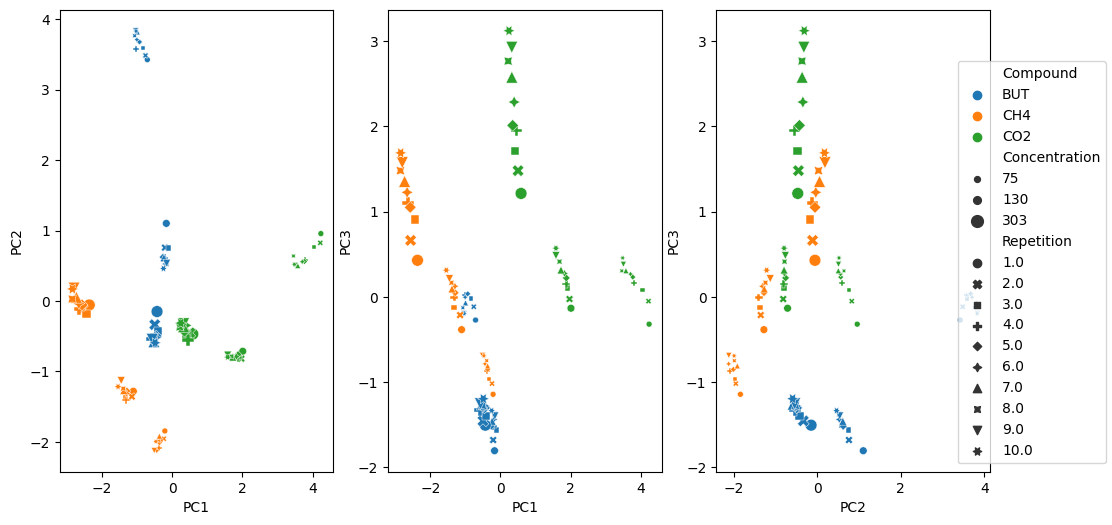

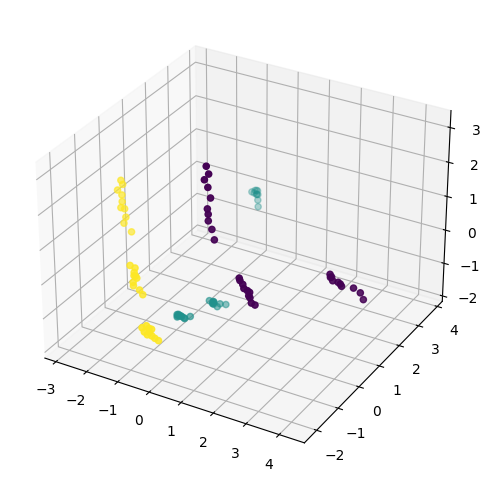

In [192]:
features_remapped_dropna = features_remapped.dropna(axis=0).copy()

features_var_dropna_norm = features_remapped_dropna.drop(
    ["Concentration", "Compound", "Repetition"], axis=1
)
features_var_dropna_norm = (
    features_var_dropna_norm - features_var_dropna_norm.min()
) / (features_var_dropna_norm.max() - features_var_dropna_norm.min())


pca = sklearn.decomposition.PCA()
x_transf = pca.fit_transform(features_var_dropna_norm)
features_remapped_dropna["PC1"] = x_transf[:, 0]
features_remapped_dropna["PC2"] = x_transf[:, 1]
features_remapped_dropna["PC3"] = x_transf[:, 2]

legend_handles = []
legend_labels = []

fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
scatter1 = sns.scatterplot(
    x="PC1",
    y="PC2",
    data=features_remapped_dropna,
    hue="Compound",
    size="Concentration",
    style="Repetition",
)
handles, labels = scatter1.get_legend_handles_labels()
legend_handles.extend(handles)
legend_labels.extend(labels)
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.subplot(1, 3, 2)
scatter2 = sns.scatterplot(
    x="PC1",
    y="PC3",
    data=features_remapped_dropna,
    hue="Compound",
    size="Concentration",
    style="Repetition",
)
plt.xlabel("PC1")
plt.ylabel("PC3")

plt.subplot(1, 3, 3)
scatter3 = sns.scatterplot(
    x="PC2",
    y="PC3",
    data=features_remapped_dropna,
    hue="Compound",
    size="Concentration",
    style="Repetition",
)
plt.xlabel("PC2")
plt.ylabel("PC3")

# Create a common legend for all subplots
scatter1.legend_.remove()
scatter2.legend_.remove()
scatter3.legend_.remove()
fig.legend(legend_handles, legend_labels, loc="center right")


features_remapped_dropna["xColor"] = 0
features_remapped_dropna.loc[features_remapped_dropna.Compound == "BUT", "xColor"] = 1
features_remapped_dropna.loc[features_remapped_dropna.Compound == "CH4", "xColor"] = 2

from mpl_toolkits.mplot3d import Axes3D

# axes instance
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection="3d")

ax.scatter(
    features_remapped_dropna["PC1"],
    features_remapped_dropna["PC2"],
    features_remapped_dropna["PC3"],
    c=features_remapped_dropna["xColor"],
)
plt.show()

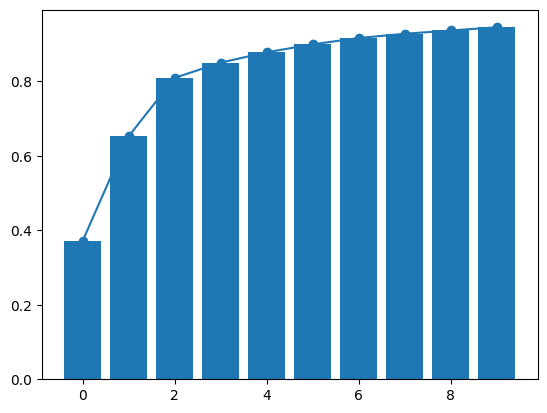

In [204]:
plt.bar(x=range(10), height=pca.explained_variance_ratio_[:10].cumsum())
plt.plot(pca.explained_variance_ratio_[:10].cumsum(), '-o')

In [206]:
pca_variance = pd.DataFrame({'Variance': pca.explained_variance_ratio_[:10].cumsum()})

In [208]:
pca_variance.to_csv('pca_variance.csv', index=True, index_label='Index')

In [131]:
export_df = features_remapped.loc[(features_remapped.Concentration == 75) & (features_remapped.Compound == "BUT"), ["S-1-SlopeH-Triangle"]].copy().reset_index(drop=True)
export_df["S-1-SlopeH-Triangle-BUT-130"] = features_remapped.loc[(features_remapped.Concentration == 130) & (features_remapped.Compound == "BUT"), ["S-1-SlopeH-Triangle"]].values
export_df["S-1-SlopeH-Triangle-BUT-300"] = features_remapped.loc[(features_remapped.Concentration == 303) & (features_remapped.Compound == "BUT"), ["S-1-SlopeH-Triangle"]].values

export_df["S-1-SlopeH-Triangle-CO2-75"] = features_remapped.loc[(features_remapped.Concentration == 75) & (features_remapped.Compound == "CO2"), ["S-1-SlopeH-Triangle"]].values
export_df["S-1-SlopeH-Triangle-CO2-130"] = features_remapped.loc[(features_remapped.Concentration == 130) & (features_remapped.Compound == "CO2"), ["S-1-SlopeH-Triangle"]].values
export_df["S-1-SlopeH-Triangle-CO2-300"] = features_remapped.loc[(features_remapped.Concentration == 303) & (features_remapped.Compound == "CO2"), ["S-1-SlopeH-Triangle"]].values

export_df["S-1-SlopeH-Triangle-CH4-75"] = features_remapped.loc[(features_remapped.Concentration == 75) & (features_remapped.Compound == "CH4"), ["S-1-SlopeH-Triangle"]].values
export_df["S-1-SlopeH-Triangle-CH4-130"] = features_remapped.loc[(features_remapped.Concentration == 130) & (features_remapped.Compound == "CH4"), ["S-1-SlopeH-Triangle"]].values
export_df["S-1-SlopeH-Triangle-CH4-300"] = features_remapped.loc[(features_remapped.Concentration == 303) & (features_remapped.Compound == "CH4"), ["S-1-SlopeH-Triangle"]].values

export_df["S-6-SlopeH-Triangle-CH4-75"] = features_remapped.loc[(features_remapped.Concentration == 75) & (features_remapped.Compound == "CH4"), ["S-6-SlopeH-Triangle"]].values
export_df["S-6-SlopeH-Triangle-CH4-130"] = features_remapped.loc[(features_remapped.Concentration == 130) & (features_remapped.Compound == "CH4"), ["S-6-SlopeH-Triangle"]].values
export_df["S-6-SlopeH-Triangle-CH4-300"] = features_remapped.loc[(features_remapped.Concentration == 303) & (features_remapped.Compound == "CH4"), ["S-6-SlopeH-Triangle"]].values

export_df["S-6-SlopeH-Triangle-CO2-75"] = features_remapped.loc[(features_remapped.Concentration == 75) & (features_remapped.Compound == "CO2"), ["S-6-SlopeH-Triangle"]].values
export_df["S-6-SlopeH-Triangle-CO2-130"] = features_remapped.loc[(features_remapped.Concentration == 130) & (features_remapped.Compound == "CO2"), ["S-6-SlopeH-Triangle"]].values
export_df["S-6-SlopeH-Triangle-CO2-300"] = features_remapped.loc[(features_remapped.Concentration == 303) & (features_remapped.Compound == "CO2"), ["S-6-SlopeH-Triangle"]].values

export_df["S-6-SlopeH-Triangle-BUT-75"] = features_remapped.loc[(features_remapped.Concentration == 75) & (features_remapped.Compound == "BUT"), ["S-6-SlopeH-Triangle"]].values
export_df["S-6-SlopeH-Triangle-BUT-130"] = features_remapped.loc[(features_remapped.Concentration == 130) & (features_remapped.Compound == "BUT"), ["S-6-SlopeH-Triangle"]].values
export_df["S-6-SlopeH-Triangle-BUT-300"] = features_remapped.loc[(features_remapped.Concentration == 303) & (features_remapped.Compound == "BUT"), ["S-6-SlopeH-Triangle"]].values

In [132]:
export_df.to_csv("boxplots_features.csv", index_label="index")

In [133]:
pca_df = pd.DataFrame()
for compound in ["BUT", "CO2", "CH4"]:
    for concentration in [75, 130, 303]:
        pca_df[f"PC1-{compound}-{concentration}"] = features_remapped_dropna.loc[(features_remapped_dropna.Compound == compound) & (features_remapped_dropna.Concentration == concentration), "PC1"].values
        pca_df[f"PC2-{compound}-{concentration}"] = features_remapped_dropna.loc[(features_remapped_dropna.Compound == compound) & (features_remapped_dropna.Concentration == concentration), "PC2"].values

In [134]:
pca_df.to_csv("pca.csv", index=False)

## PCA Single Temperature Modulation Pattern

Sine
['Concentration', 'Compound', 'Repetition', 'S-1-DeltaH-Square', 'S-1-DeltaH-Triangle', 'S-1-DeltaH-Sq+Tr', 'S-1-DeltaL-Square', 'S-1-DeltaL-Triangle', 'S-1-DeltaL-Sq+Tr', 'S-1-SlopeH-Square', 'S-1-SlopeH-Triangle', 'S-1-SlopeH-Sq+Tr', 'S-1-SlopeL-Square', 'S-1-SlopeL-Triangle', 'S-1-SlopeL-Sq+Tr', 'S-2-DeltaH-Square', 'S-2-DeltaH-Triangle', 'S-2-DeltaH-Sq+Tr', 'S-2-DeltaL-Square', 'S-2-DeltaL-Triangle', 'S-2-DeltaL-Sq+Tr', 'S-2-SlopeH-Square', 'S-2-SlopeH-Triangle', 'S-2-SlopeH-Sq+Tr', 'S-2-SlopeL-Square', 'S-2-SlopeL-Triangle', 'S-2-SlopeL-Sq+Tr', 'S-3-DeltaH-Square', 'S-3-DeltaH-Triangle', 'S-3-DeltaH-Sq+Tr', 'S-3-DeltaL-Square', 'S-3-DeltaL-Triangle', 'S-3-DeltaL-Sq+Tr', 'S-3-SlopeH-Square', 'S-3-SlopeH-Triangle', 'S-3-SlopeH-Sq+Tr', 'S-3-SlopeL-Square', 'S-3-SlopeL-Triangle', 'S-3-SlopeL-Sq+Tr', 'S-4-DeltaH-Square', 'S-4-DeltaH-Triangle', 'S-4-DeltaH-Sq+Tr', 'S-4-DeltaL-Square', 'S-4-DeltaL-Triangle', 'S-4-DeltaL-Sq+Tr', 'S-4-SlopeH-Square', 'S-4-SlopeH-Triangle', 'S-4-SlopeH

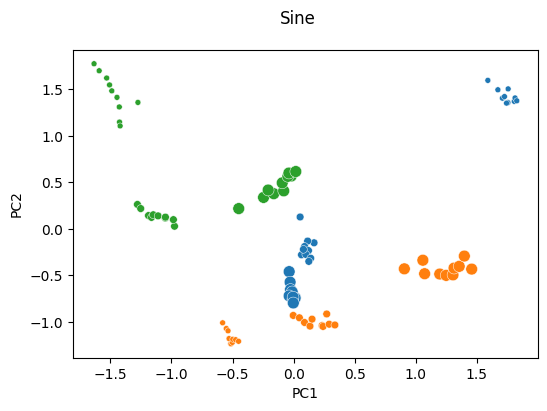

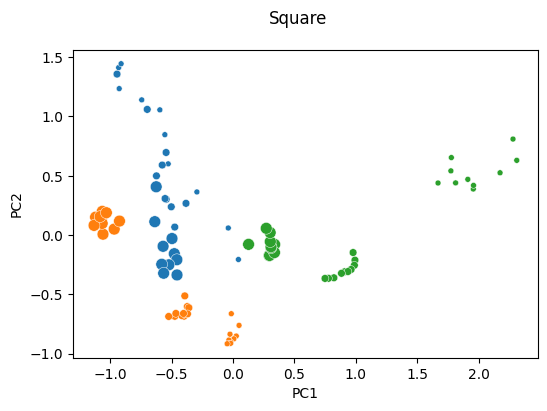

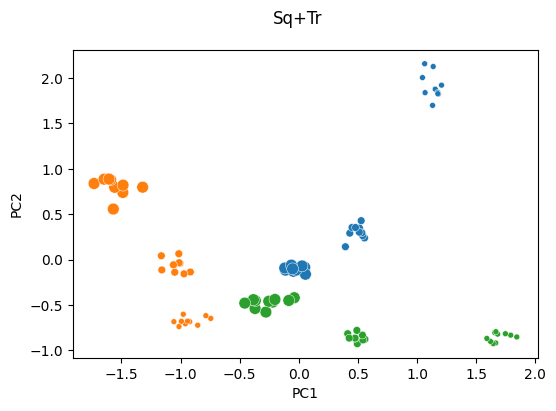

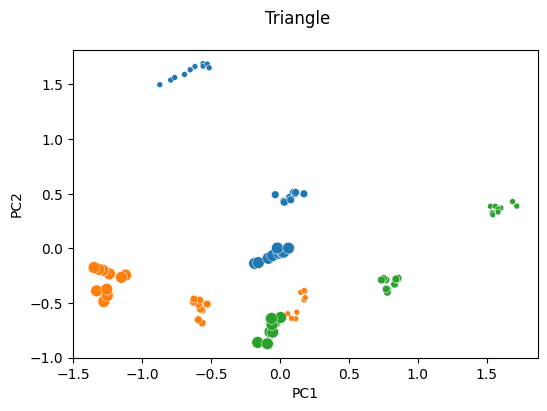

In [172]:
pca_tm = pd.DataFrame()
for temperature_modulation in ["Sine", "Square", "Sq+Tr", "Triangle"]:
    print(temperature_modulation)
    features_remapped_dropna = features_remapped.dropna(axis=0).copy()
    columns_to_drop = []
    for col in features_remapped_dropna.columns:
        if temperature_modulation not in col:
            columns_to_drop.append(col)
    print(columns_to_drop)
    features_var_dropna_norm = features_remapped_dropna.drop(
        columns_to_drop, axis=1
    )
    
    features_var_dropna_norm = (
        features_var_dropna_norm - features_var_dropna_norm.min()
    ) / (features_var_dropna_norm.max() - features_var_dropna_norm.min())


    pca = sklearn.decomposition.PCA()
    x_transf = pca.fit_transform(features_var_dropna_norm)
    features_remapped_dropna["PC1"] = x_transf[:, 0]
    features_remapped_dropna["PC2"] = x_transf[:, 1]
    features_remapped_dropna["PC3"] = x_transf[:, 2]
    
    for compound in features_remapped_dropna.Compound.unique():
        for concentration in features_remapped_dropna.Concentration.unique():
            pca_tm[f"PC1-{temperature_modulation}-{compound}-{concentration}"] = features_remapped_dropna.loc[(features_remapped_dropna.Compound == compound) & (features_remapped_dropna.Concentration == concentration), "PC1"].values
            pca_tm[f"PC2-{temperature_modulation}-{compound}-{concentration}"] = features_remapped_dropna.loc[(features_remapped_dropna.Compound == compound) & (features_remapped_dropna.Concentration == concentration), "PC2"].values
    

    legend_handles = []
    legend_labels = []

    fig = plt.figure(figsize=(6, 4))
    plt.suptitle(temperature_modulation)
    plt.subplot(1, 1, 1)
    scatter1 = sns.scatterplot(
        x="PC1",
        y="PC2",
        data=features_remapped_dropna,
        hue="Compound",
        size="Concentration",
        #style="Repetition",
    )
    handles, labels = scatter1.get_legend_handles_labels()
    legend_handles.extend(handles)
    legend_labels.extend(labels)
    plt.xlabel("PC1")
    plt.ylabel("PC2")

    # Create a common legend for all subplots
    scatter1.legend_.remove()

In [152]:
pca_tm.to_csv('pca_tm.csv', index=False)

['S-1', 'S-2', 'S-3', 'S-4']
['S-5', 'S-6']
['S-7', 'S-8']


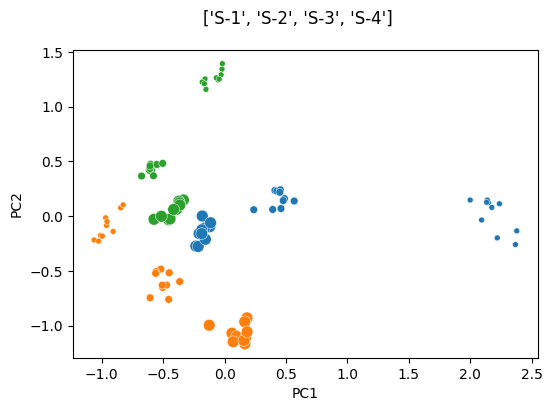

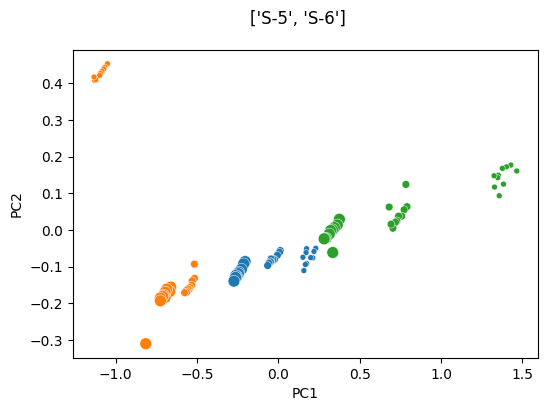

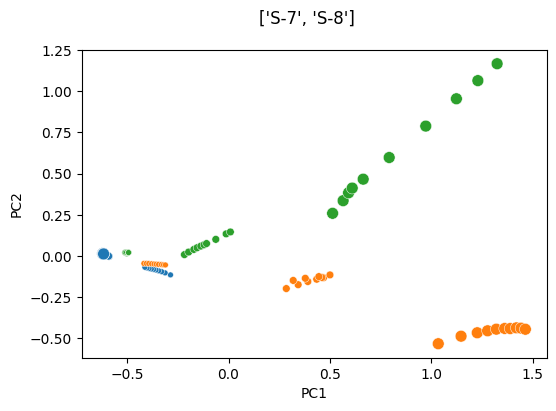

In [173]:
pca_re_tr = pd.DataFrame()
for sensor_idx, sensor_group in enumerate([["S-1", "S-2", "S-3", "S-4"], ["S-5", "S-6"], ["S-7", "S-8"]]):
    print(sensor_group)
    features_remapped_dropna = features_remapped.dropna(axis=0).copy()
    columns_to_keep = []
    for col in features_remapped_dropna.columns:
        for sensor in sensor_group:
            if (sensor in col) and (col not in columns_to_keep) and ("Sq+Tr" in col):
                columns_to_keep.append(col)
    columns_to_drop = []
    for col in features_remapped_dropna.columns:
        if col not in columns_to_keep:
            columns_to_drop.append(col)
    features_var_dropna_norm = features_remapped_dropna.drop(
        columns_to_drop, axis=1
    )
    
    features_var_dropna_norm = (
        features_var_dropna_norm - features_var_dropna_norm.min()
    ) / (features_var_dropna_norm.max() - features_var_dropna_norm.min())


    pca = sklearn.decomposition.PCA()
    x_transf = pca.fit_transform(features_var_dropna_norm)
    features_remapped_dropna["PC1"] = x_transf[:, 0]
    features_remapped_dropna["PC2"] = x_transf[:, 1]
    features_remapped_dropna["PC3"] = x_transf[:, 2]
    
    for compound in features_remapped_dropna.Compound.unique():
        for concentration in features_remapped_dropna.Concentration.unique():
            pca_re_tr[f"PC1-{compound}-{concentration}-{sensor_idx}"] = features_remapped_dropna.loc[(features_remapped_dropna.Compound == compound) & (features_remapped_dropna.Concentration == concentration), "PC1"].values
            pca_re_tr[f"PC2-{compound}-{concentration}-{sensor_idx}"] = features_remapped_dropna.loc[(features_remapped_dropna.Compound == compound) & (features_remapped_dropna.Concentration == concentration), "PC2"].values
    

    legend_handles = []
    legend_labels = []

    fig = plt.figure(figsize=(6, 4))
    plt.suptitle(sensor_group)
    plt.subplot(1, 1, 1)
    scatter1 = sns.scatterplot(
        x="PC1",
        y="PC2",
        data=features_remapped_dropna,
        hue="Compound",
        size="Concentration",
        #style="Repetition",
    )
    handles, labels = scatter1.get_legend_handles_labels()
    legend_handles.extend(handles)
    legend_labels.extend(labels)
    plt.xlabel("PC1")
    plt.ylabel("PC2")


    # Create a common legend for all subplots
    scatter1.legend_.remove()

In [175]:
pca_re_tr.to_csv('pca_re_tr.csv', index=False)